In [3]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

from matplotlib.path import Path
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from cell_utilities import *

In [4]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

ImportError: No module named xgboost.sklearn

In [5]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [500] # (100 um, 250 um)
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Generate training addresses

In [12]:
training_addresses_by_section = []

# for stack in all_annotated_nissl_stacks:
for stack in ['MD589']:
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    
    t1 = time.time()
    
    contours_df = read_hdf(ANNOTATION_ROOTDIR + '/%(stack)s/%(stack)s_annotation_v3.h5' % dict(stack=stack), 'contours')
    labeled_contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    labeled_contours = labeled_contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])
    labeled_contours = convert_annotation_v3_original_to_aligned_cropped(labeled_contours, stack=stack)
    
    sys.stderr.write('Load annotation. Time: %.2s seconds.\n' % (time.time() - t1))
    
    def label_region_worker(sec):
    
        training_addresses = {}

        if is_invalid(stack=stack, sec=sec):
            return

        region_contours = bp.unpack_ndarray_file(get_cell_classifier_data_filepath(what='region_contours', stack=stack, sec=sec, ext='bp'))
        region_labels = label_regions(stack=stack, section=sec, region_contours=region_contours,
                                      surround_margins=margins_to_sample,
                                      labeled_contours=labeled_contours[labeled_contours['section'] == sec])

        for label, region_indices in region_labels.iteritems():
            if label == 'bg' or len(region_indices) == 0:
                continue
            sampled_region_indices = np.random.choice(region_indices, min(10, len(region_indices)), replace=False)
            training_addresses[label] = [(stack, sec, ridx) for ridx in sampled_region_indices]

        return training_addresses
    
    t1 = time.time()
    
    pool = Pool(8)
    training_addresses_by_section_curr_stack = pool.map(lambda sec: label_region_worker(sec), range(first_sec, last_sec+1))
    pool.close()
    pool.join()
    
    training_addresses_by_section += training_addresses_by_section_curr_stack
    
    sys.stderr.write('Sample training addresses. Time: %.2s seconds.\n' % (time.time() - t1)) # 13 seconds.
    
training_addresses = defaultdict(list)
for train_addrs_by_label in training_addresses_by_section:
    if train_addrs_by_label is None: continue
    for label, addrs in train_addrs_by_label.iteritems():
        training_addresses[label] += addrs

Load annotation. Time: 1. seconds.
Analyzing section 110..
Analyzing section 101..
Analyzing section 128..
Analyzing section 155..
Analyzing section 137..
Analyzing section 92..
Analyzing section 119..
Analyzing section 93..
Analyzing section 146..
Analyzing section 94..
Analyzing section 95..
Analyzing section 102..
Analyzing section 111..
Analyzing section 96..
Analyzing section 120..
Analyzing section 103..
Analyzing section 129..
Analyzing section 97..
Analyzing section 98..
Analyzing section 104..
Analyzing section 112..
Analyzing section 147..
Analyzing section 99..
Analyzing section 138..
Analyzing section 130..
Analyzing section 100..
Analyzing section 121..
Analyzing section 113..
Analyzing section 105..
Analyzing section 164..
Analyzing section 156..
Analyzing section 106..
Analyzing section 114..
Analyzing section 122..
Analyzing section 131..
Analyzing section 148..
Analyzing section 139..
Analyzing section 107..
Analyzing section 115..
Analyzing section 123..
Analyzing sec

In [6]:
# Load training addresses

dataset = 5

training_addresses = load_pickle(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_addresses.pkl'))

In [5]:
for label, train_addrs in training_addresses.iteritems():
    print label, len(train_addrs)

Amb_surround_500_7N 3
12N_surround_500_AP 13
4N_negative 120
RtTg_negative 150
Tz_negative 500
SNC_surround_500_SNR 830
SNR_surround_500_SNC 327
SNR_surround_500_PBG 3
5N 440
Sp5I_surround_500_Sp5C 210
VCP_surround_500_noclass 490
Sp5I_surround_500_Sp5O 370
LRt_negative 760
6N_surround_500_7n 9
12N 390
3N_surround_500_noclass 240
6N_negative 50
LC_negative 240
Sp5O 370
Pn_surround_500_noclass 1010
Sp5I 499
VCA_surround_500_noclass 660
Sp5C 900
12N_surround_500_noclass 390
SNC 327
SC_surround_500_IC 1640
Amb_negative 130
LC_surround_500_noclass 240
4N_surround_500_3N 60
DC_surround_500_VCA 314
7n_negative 1250
DC_surround_500_VCP 399
noclass 2730
SNC_surround_500_noclass 830
AP_negative 150
RtTg 150
Pn 960
RMC_negative 570
10N 10
VLL 690
LRt_surround_500_Sp5C 98
RtTg_surround_500_Tz 43
VCP_negative 490
SNC_negative 830
IC_surround_500_noclass 1640
PBG_surround_500_noclass 260
Sp5O_negative 390
SNR 1100
PBG_surround_500_SNR 17
Sp5O_surround_500_Sp5I 390
PBG 133
Sp5C_negative 900
IC_negat

# Generate training features

In [4]:
def load_features_(stack, section, region_indices):
    """
    """
    
    region_features_all_regions = load_hdf_v2(get_cell_classifier_data_filepath(what='region_features', stack=stack, sec=section, ext='hdf'))
    # Loading hdf ~ 2 seconds.
    
    features1 = np.asarray([rf['largeOrientationHist'] for rf in region_features_all_regions])
    features2 = np.asarray([rf['largeSizeHist'] for rf in region_features_all_regions])
    features3 = np.asarray([rf['largeLargeLinkLenHist'] for rf in region_features_all_regions])
    features4 = np.asarray([rf['largeSmallLinkLenHist'] for rf in region_features_all_regions])
    
        
    f1 = features1[region_indices]
    f1n = f1/f1.sum(axis=1)[:,None].astype(np.float)
    
    f2 = features2[region_indices]
    f2n = f2/f2.sum(axis=1)[:,None].astype(np.float)
    
    f3 = features3[region_indices]
    f3n = f3/f3.sum(axis=1)[:,None].astype(np.float)
    
    f4 = features4[region_indices]
    f4n = f4/f4.sum(axis=1)[:,None].astype(np.float)
    
    features = np.c_[f1n, f2n, f3n, f4n]
    
    return features

In [5]:
t = time.time()

func_for_list = lambda addrs: smart_map(addrs, keyfunc=lambda (st, se, ri): (st, se),
                       func=lambda (st, se), gr: load_features_(st, se, [ri for _,_,ri in gr]))

training_features = apply_function_to_dict(func_for_list, 
                                           training_addresses)
#                        {i: t for i, t in training_addresses.iteritems() if i in ['7N', '5N']})

training_features = apply_function_to_dict(np.asarray, training_features)

sys.stderr.write('Load features: %.2f seconds.\n' % (time.time() - t)) # 40 seconds for 64k addresses

Load features: 44.60 seconds.


In [6]:
# Remove features with invalid values.

training_addresses_invalid_removed = {}
training_features_invalid_removed = {}
for label, feats in training_features.iteritems():
    invalid_indices = np.where(np.any(np.isnan(feats), axis=1))[0]
    print label, '\t\t', len(invalid_indices)
    valid_indices = np.setdiff1d(np.arange(len(feats)), invalid_indices)
    
    training_addresses_invalid_removed[label] = [training_addresses[label][i] for i in valid_indices]
    training_features_invalid_removed[label] = training_features[label][valid_indices]    

Amb_surround_500_7N 		0
4N_negative 		28
AP_negative 		51
Tz_negative 		67
SNC_surround_500_SNR 		51
SNR_surround_500_SNC 		9
SNR_surround_500_PBG 		0
5N 		6
Sp5I_surround_500_Sp5C 		0
SNC_surround_500_noclass 		40
Sp5I_surround_500_Sp5O 		0
LRt_negative 		120
6N_surround_500_7n 		39
12N 		3
3N_surround_500_noclass 		11
6N_negative 		42
LC_negative 		27
Sp5O 		10
Pn_surround_500_noclass 		108
Sp5I 		0
VCA_surround_500_noclass 		105
Sp5C 		6
12N_surround_500_noclass 		22
3N_surround_500_4N 		0
SNC 		9
SC_surround_500_IC 		5
Amb_negative 		14
LC_surround_500_noclass 		7
4N_surround_500_3N 		0
DC_surround_500_VCA 		0
7n_negative 		198
DC_surround_500_VCP 		4
noclass 		660
3N 		10
Pn 		13
RMC_negative 		81
10N 		0
VLL 		4
RtTg_surround_500_Tz 		0
VCP_negative 		169
SNC_negative 		161
IC_surround_500_noclass 		325
PBG_surround_500_noclass 		22
Sp5O_negative 		100
SNR 		159
Pn_surround_500_Tz 		0
PBG_surround_500_SNR 		8
SC 		0
PBG 		6
Sp5C_negative 		225
IC_negative 		210
SNR_negative 		204

In [7]:
training_addresses = training_addresses_invalid_removed
training_features = training_features_invalid_removed

In [8]:
# Save this set as dataset.

dataset = 9

train_feat_dir = create_if_not_exists(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features'))

# Save training features
for label, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, label + '.bp'))
    
# Save training addresses
save_pickle(training_addresses, os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_addresses.pkl'))

# Load dataset

In [61]:
# Load multiple datasets

training_features = {}

for dataset in [7,8]:
    train_feat_dir = os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features')
    
    for label in labels_to_sample:
        try:
            if label not in training_features:
                training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
            else:
                training_features[label] = np.vstack([training_features[label], 
                                                     bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))])
        except Exception as e:
            continue

In [42]:
# Load a single dataset

dataset = 7

train_feat_dir = os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features')

training_features = {}
for label in labels_to_sample:
    try:
        training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
    except:
        continue

In [62]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [63]:
setting = 21
setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % setting))
margin = 500

In [64]:
# train svm classifiers

clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:
    
    t = time.time()

    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    ###################################
    # Define training set composition #
    ###################################
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
    
    n_neg = len(features_neg)
    
    ###########################
    ## Define Sample Weights ##
    ###########################
    
    if setting == 9:
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    sys.stderr.write('%d, %d\n' % (n_pos, n_neg))
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    ##################
    ## Define Model ##
    ##################
    
    if setting in [1, 2, 8, 9, 10, 11, 14, 15]:
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
    elif setting in [3, 16]:
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif setting == 4:
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif setting in [5, 17, 18]:        
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif setting in [6,13, 19, 20]:
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif setting in [7, 21, 22]:        
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        raise Exception('Setting is not recognized.')
 
    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier %s: %.2f seconds\n' % (structure, time.time() - t))
    
    joblib.dump(clf, os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=setting)))

919, 1375


      Iter       Train Loss   Remaining Time 
         1           1.0696            1.21s
         2           0.9146            1.18s
         3           0.8080            1.16s
         4           0.7338            1.15s
         5           0.6786            1.14s
         6           0.6341            1.12s
         7           0.5914            1.11s
         8           0.5564            1.10s
         9           0.5312            1.08s
        10           0.5085            1.06s
        20           0.3482            0.88s
        30           0.2600            0.74s
        40           0.1971            0.61s
        50           0.1407            0.51s
        60           0.1026            0.41s
        70           0.0719            0.31s
        80           0.0519            0.21s
        90           0.0402            0.10s
       100           0.0293            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1894            0.95s
        

Fitting classifier Tz: 1.04 seconds
682, 1290


         4           1.0231            0.86s
         5           0.9800            0.88s
         6           0.9409            0.88s
         7           0.9115            0.85s
         8           0.8862            0.82s
         9           0.8536            0.81s
        10           0.8225            0.82s
        20           0.6493            0.67s
        30           0.5120            0.58s
        40           0.4210            0.49s
        50           0.3323            0.41s
        60           0.2654            0.33s
        70           0.2079            0.25s
        80           0.1736            0.16s
        90           0.1440            0.08s
       100           0.1131            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8127            1.11s
         2           0.7304            1.05s
         3           0.6732            1.07s


Fitting classifier Sp5O: 0.83 seconds
541, 2285


         4           0.6329            1.08s
         5           0.5988            1.06s
         6           0.5664            1.04s
         7           0.5441            1.02s
         8           0.5233            1.02s
         9           0.5099            0.98s
        10           0.4923            0.96s
        20           0.3829            0.84s
        30           0.3176            0.69s
        40           0.2638            0.59s
        50           0.2087            0.49s
        60           0.1692            0.39s
        70           0.1363            0.30s
        80           0.1115            0.20s
        90           0.0956            0.10s
       100           0.0799            0.00s
      Iter       Train Loss   Remaining Time 


Fitting classifier 7n: 0.98 seconds
1733, 3139


         1           1.2070            2.47s
         2           1.1364            2.49s
         3           1.0879            2.40s
         4           1.0311            2.43s
         5           0.9981            2.38s
         6           0.9667            2.34s
         7           0.9396            2.34s
         8           0.9159            2.32s
         9           0.8904            2.31s
        10           0.8734            2.26s
        20           0.7083            1.95s
        30           0.5988            1.69s
        40           0.5002            1.44s
        50           0.4413            1.17s
        60           0.3862            0.93s
        70           0.3340            0.69s
        80           0.2824            0.46s
        90           0.2427            0.23s
       100           0.2081            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2000            0.85s
         2           1.0839            0.81s
         

Fitting classifier DC: 2.33 seconds
898, 897


        20           0.5484            0.60s
        30           0.4123            0.53s
        40           0.3380            0.44s
        50           0.2603            0.37s
        60           0.2086            0.29s
        70           0.1656            0.22s
        80           0.1320            0.14s
        90           0.1008            0.07s
       100           0.0757            0.00s


Fitting classifier 5N: 0.74 seconds
479, 485


      Iter       Train Loss   Remaining Time 
         1           1.1259            0.55s
         2           0.9499            0.54s
         3           0.8384            0.53s
         4           0.7659            0.51s
         5           0.6959            0.51s
         6           0.6419            0.51s
         7           0.5907            0.50s
         8           0.5526            0.49s
         9           0.5106            0.48s
        10           0.4798            0.48s
        20           0.2732            0.40s
        30           0.1679            0.34s
        40           0.1078            0.29s
        50           0.0609            0.25s
        60           0.0361            0.20s
        70           0.0209            0.15s
        80           0.0131            0.10s
        90           0.0080            0.05s
       100           0.0051            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1923            2.22s
        

Fitting classifier 3N: 0.50 seconds
1770, 2366


         4           0.9279            2.16s
         5           0.8763            2.12s
         6           0.8389            2.06s
         7           0.8019            2.05s
         8           0.7752            2.00s
         9           0.7547            1.93s
        10           0.7329            1.90s
        20           0.5669            1.61s
        30           0.4710            1.36s
        40           0.3782            1.17s
        50           0.3151            0.96s
        60           0.2565            0.77s
        70           0.2115            0.58s
        80           0.1807            0.38s
        90           0.1480            0.19s
       100           0.1267            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5895            0.88s
         2           0.5232            0.87s
         3           0.4685            0.87s
         4           0.4305            0.84s
         5           0.3875            0.87s
         

Fitting classifier Pn: 1.90 seconds
212, 1508


        20           0.1760            0.66s
        30           0.0952            0.58s
        40           0.0618            0.49s
        50           0.0400            0.41s
        60           0.0241            0.33s
        70           0.0140            0.25s
        80           0.0086            0.17s
        90           0.0052            0.08s
       100           0.0032            0.00s


Fitting classifier 10N: 0.84 seconds
420, 426


      Iter       Train Loss   Remaining Time 
         1           1.1761            0.46s
         2           1.0237            0.49s
         3           0.9252            0.48s
         4           0.8484            0.47s
         5           0.7873            0.45s
         6           0.7354            0.44s
         7           0.6875            0.44s
         8           0.6559            0.43s
         9           0.6184            0.42s
        10           0.5898            0.41s
        20           0.3360            0.35s
        30           0.2074            0.30s
        40           0.1284            0.26s
        50           0.0779            0.22s
        60           0.0498            0.17s
        70           0.0322            0.13s
        80           0.0203            0.09s
        90           0.0125            0.04s
       100           0.0083            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1652            1.75s
        

Fitting classifier LC: 0.44 seconds
1674, 1694


         9           0.7624            1.46s
        10           0.7421            1.44s
        20           0.6145            1.17s
        30           0.5283            0.98s
        40           0.4405            0.83s
        50           0.3691            0.68s
        60           0.3087            0.54s
        70           0.2671            0.40s
        80           0.2243            0.27s
        90           0.1804            0.14s
       100           0.1482            0.00s


Fitting classifier 7N: 1.38 seconds
212, 274


      Iter       Train Loss   Remaining Time 
         1           1.0498            0.27s
         2           0.8608            0.26s
         3           0.7301            0.26s
         4           0.6364            0.25s
         5           0.5492            0.26s
         6           0.4775            0.25s
         7           0.4196            0.25s
         8           0.3748            0.25s
         9           0.3346            0.24s
        10           0.3026            0.24s
        20           0.1092            0.21s
        30           0.0426            0.18s
        40           0.0168            0.15s
        50           0.0066            0.13s
        60           0.0029            0.10s
        70           0.0011            0.08s
        80           0.0005            0.05s
        90           0.0004            0.02s
       100           0.0004            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1647            0.83s
        

Fitting classifier Amb: 0.22 seconds
748, 965


        20           0.4421            0.64s
        30           0.3463            0.53s
        40           0.2462            0.46s
        50           0.1921            0.37s
        60           0.1336            0.31s
        70           0.1002            0.23s
        80           0.0765            0.15s
        90           0.0564            0.08s
       100           0.0394            0.00s


Fitting classifier 12N: 0.78 seconds
1236, 1235


      Iter       Train Loss   Remaining Time 
         1           1.1764            1.19s
         2           1.0465            1.23s
         3           0.9652            1.21s
         4           0.9044            1.19s
         5           0.8578            1.19s
         6           0.8247            1.17s
         7           0.7970            1.14s
         8           0.7696            1.13s
         9           0.7477            1.09s
        10           0.7344            1.05s
        20           0.6076            0.83s
        30           0.4910            0.71s
        40           0.4008            0.60s
        50           0.3128            0.50s
        60           0.2446            0.41s
        70           0.1998            0.30s
        80           0.1555            0.20s
        90           0.1288            0.10s
       100           0.1041            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1297            2.03s


Fitting classifier RMC: 1.03 seconds
1193, 2418


         2           1.0456            2.01s
         3           0.9840            1.98s
         4           0.9360            1.94s
         5           0.8962            1.91s
         6           0.8597            1.89s
         7           0.8294            1.86s
         8           0.8063            1.82s
         9           0.7839            1.77s
        10           0.7592            1.75s
        20           0.5837            1.49s
        30           0.4752            1.26s
        40           0.4021            1.04s
        50           0.3235            0.87s
        60           0.2575            0.70s
        70           0.2166            0.52s
        80           0.1764            0.35s
        90           0.1475            0.17s
       100           0.1190            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1607            1.49s
         2           1.0929            1.49s
         3           1.0451            1.46s
         

Fitting classifier VCA: 1.74 seconds
888, 1885


        10           0.8407            1.23s
        20           0.6786            1.03s
        30           0.5522            0.88s
        40           0.4535            0.75s
        50           0.3605            0.63s
        60           0.2871            0.51s
        70           0.2453            0.37s
        80           0.2027            0.25s
        90           0.1650            0.12s
       100           0.1377            0.00s
      Iter       Train Loss   Remaining Time 


Fitting classifier Sp5I: 1.25 seconds
1341, 1760


         1           1.2715            1.56s
         2           1.2091            1.51s
         3           1.1525            1.54s
         4           1.1081            1.52s
         5           1.0696            1.48s
         6           1.0251            1.50s
         7           0.9880            1.50s
         8           0.9620            1.48s
         9           0.9347            1.46s
        10           0.9143            1.43s
        20           0.7365            1.23s
        30           0.6184            1.04s
        40           0.5133            0.89s
        50           0.4232            0.74s
        60           0.3486            0.59s
        70           0.3022            0.44s
        80           0.2516            0.29s
        90           0.2128            0.15s
       100           0.1811            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.2214            0.15s
         2           0.1812            0.18s
         

Fitting classifier Sp5C: 1.47 seconds
19, 457
Fitting classifier 4N: 0.13 seconds
266, 319


      Iter       Train Loss   Remaining Time 
         1           1.1321            0.34s
         2           0.9680            0.34s
         3           0.8645            0.33s
         4           0.7675            0.32s
         5           0.6871            0.32s
         6           0.6263            0.32s
         7           0.5643            0.32s
         8           0.5212            0.31s
         9           0.4859            0.30s
        10           0.4542            0.30s
        20           0.2238            0.26s
        30           0.1200            0.22s
        40           0.0665            0.19s
        50           0.0352            0.16s
        60           0.0199            0.13s
        70           0.0121            0.09s
        80           0.0061            0.06s
        90           0.0036            0.03s
       100           0.0021            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9868            0.54s
        

Fitting classifier AP: 0.32 seconds
360, 626


         9           0.3742            0.50s
        10           0.3444            0.49s
        20           0.1781            0.41s
        30           0.0849            0.36s
        40           0.0461            0.31s
        50           0.0271            0.25s
        60           0.0142            0.20s
        70           0.0087            0.15s
        80           0.0048            0.10s
        90           0.0027            0.05s
       100           0.0015            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1582            1.12s
         2           1.0310            1.09s
         3           0.9433            1.08s
         4           0.8741            1.06s
         5           0.8305            1.03s
         6           0.7897            1.01s
         7           0.7470            1.01s
         8           0.7172            0.99s
         9           0.6876            0.97s
        10           0.6702            0.93s


Fitting classifier PBG: 0.50 seconds
944, 1045


        20           0.5083            0.75s
        30           0.3987            0.63s
        40           0.3341            0.51s
        50           0.2508            0.43s
        60           0.1915            0.34s
        70           0.1393            0.26s
        80           0.1092            0.18s
        90           0.0831            0.09s
       100           0.0643            0.00s


Fitting classifier LRt: 0.89 seconds
3313, 6015


      Iter       Train Loss   Remaining Time 
         1           1.2342            4.49s
         2           1.1852            4.58s
         3           1.1473            4.54s
         4           1.1192            4.53s
         5           1.0945            4.44s
         6           1.0728            4.42s
         7           1.0549            4.28s
         8           1.0410            4.17s
         9           1.0275            4.13s
        10           1.0115            4.10s
        20           0.9197            3.48s
        30           0.8413            3.02s
        40           0.7703            2.58s
        50           0.7149            2.13s
        60           0.6651            1.68s
        70           0.6094            1.27s
        80           0.5617            0.84s
        90           0.5179            0.42s
       100           0.4857            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1819            1.14s
        

Fitting classifier IC: 4.22 seconds
1181, 1070


        20           0.5091            0.86s
        30           0.3739            0.74s
        40           0.2906            0.62s
        50           0.2197            0.52s
        60           0.1685            0.41s
        70           0.1273            0.31s
        80           0.0971            0.21s
        90           0.0765            0.10s
       100           0.0586            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0611            1.84s
         2           1.0156            1.71s
         3           0.9721            1.70s
         4           0.9397            1.65s
         5           0.9060            1.64s
         6           0.8884            1.54s
         7           0.8632            1.49s
         8           0.8396            1.48s


Fitting classifier VLL: 1.04 seconds
859, 2481


         9           0.8273            1.42s
        10           0.8088            1.38s
        20           0.6524            1.19s
        30           0.5237            1.05s
        40           0.4215            0.90s
        50           0.3554            0.74s
        60           0.2866            0.60s
        70           0.2539            0.44s
        80           0.1940            0.30s
        90           0.1625            0.15s
       100           0.1298            0.00s


Fitting classifier VCP: 1.50 seconds
741, 3155


      Iter       Train Loss   Remaining Time 
         1           0.8726            2.03s
         2           0.8107            1.87s
         3           0.7723            1.70s
         4           0.7357            1.75s
         5           0.7079            1.74s
         6           0.6815            1.73s
         7           0.6570            1.71s
         8           0.6433            1.66s
         9           0.6270            1.64s
        10           0.6119            1.61s
        20           0.4759            1.40s
        30           0.3715            1.23s
        40           0.2994            1.04s
        50           0.2449            0.86s
        60           0.1986            0.68s
        70           0.1605            0.51s
        80           0.1290            0.34s
        90           0.1087            0.17s
       100           0.0906            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8512            0.17s
        

Fitting classifier SNC: 1.70 seconds
102, 263
Fitting classifier 6N: 0.13 seconds
2176, 2846


      Iter       Train Loss   Remaining Time 
         1           1.2964            2.56s
         2           1.2512            2.53s
         3           1.2194            2.27s
         4           1.1858            2.32s
         5           1.1537            2.30s
         6           1.1318            2.21s
         7           1.1123            2.12s
         8           1.0934            2.07s
         9           1.0729            2.04s
        10           1.0624            1.97s
        20           0.9332            1.68s
        30           0.8433            1.43s
        40           0.7688            1.19s
        50           0.6975            0.99s
        60           0.6171            0.80s
        70           0.5518            0.61s
        80           0.5068            0.40s
        90           0.4635            0.20s
       100           0.4186            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2407            5.60s
        

Fitting classifier SNR: 2.02 seconds
3524, 6628


         3           1.1885            5.33s
         4           1.1680            5.27s
         5           1.1526            5.09s
         6           1.1404            4.86s
         7           1.1274            4.77s
         8           1.1158            4.68s
         9           1.1025            4.58s
        10           1.0948            4.41s
        20           1.0134            3.70s
        30           0.9551            3.08s
        40           0.8842            2.71s
        50           0.8224            2.26s
        60           0.7655            1.80s
        70           0.7325            1.32s
        80           0.6942            0.87s
        90           0.6508            0.44s
       100           0.6097            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1845            1.51s
         2           1.1151            1.46s
         3           1.0549            1.43s
         4           1.0033            1.43s
         

Fitting classifier SC: 4.40 seconds
964, 1799


        10           0.8258            1.27s
        20           0.6682            1.04s
        30           0.5511            0.86s
        40           0.4557            0.72s
        50           0.3841            0.60s
        60           0.3252            0.47s
        70           0.2644            0.36s
        80           0.2163            0.24s
        90           0.1788            0.12s
       100           0.1473            0.00s


Fitting classifier RtTg: 1.21 seconds


# Load pre-computed classifiers

In [65]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for sp5 is found.
No classifier for outerContour is found.


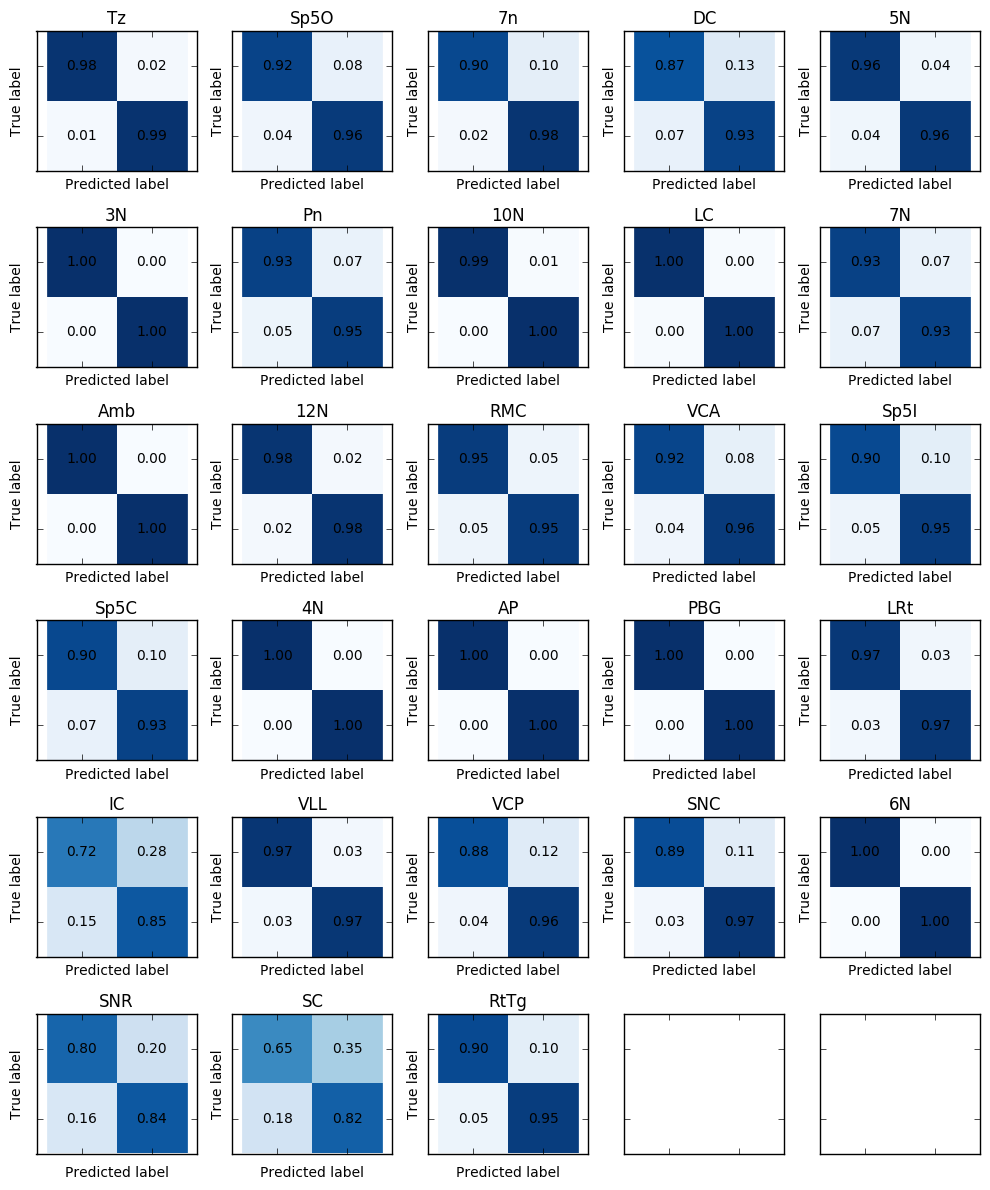

In [66]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:        
        raise Exception('Setting is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [67]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.946748417414
